# CNN Model using full Ford data now

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Normalization
%matplotlib inline
import seaborn as sns
from keras.models import Sequential 
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, InputLayer
from keras.utils.np_utils import to_categorical

from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


## Part 1: Clean and Select Data

In [52]:
pd.set_option('display.max_columns', None)

In [53]:
Ford = pd.read_csv("Ford_Cleaned_Date.csv")
Ford.date = pd.to_datetime(Ford.date)
Ford = Ford.set_index("date")
Ford = Ford.iloc[14:, :] # to remove first 14 days that include NaNs due to some calculations
pd.DataFrame(Ford.isna().sum()).T

,Ford,F-150,Ford Bronco_x,Ford Mustang_x,Ford Stock,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ford Motor Company,Ford Mustang_y,Ford F Series,Ford Bronco_y,Lincoln Navigator,Lincoln Aviator,Ford GT,dow_open,dow_high,dow_low,dow_close,dow_vol,nas_open,nas_high,nas_low,nas_close,nas_vol,Wiki_total,Google_total,Stock_total,Nas_total,Dow_total,Wiki_Moment_1,Wiki_Moment_2,Wiki_Moment_1_s,Wiki_Moment_2_s,Wiki_MAvg,Wiki_MAvg_s,Wiki_Disparity,Wiki_Disparity_s,Wiki_ROC,Wiki_ROC_s,Wiki_Rocp,Wiki_EMA,Wiki_diff,Wiki_gain,Wiki_loss,Wiki_avg_gain,Wiki_avg_loss,Wiki_rs,Wiki_RSI,Wiki_Move,Wiki_MAvg_Move,Wiki_MAvg_s_Move,Wiki_EMA_Move,Wiki_Disparity_Move,Wiki_Disparity_s_Move,Wiki_RSI_Move,Google_Moment_1,Google_Moment_2,Google_Moment_1_s,Google_Moment_2_s,Google_MAvg,Google_MAvg_s,Google_Disparity,Google_Disparity_s,Google_ROC,Google_ROC_s,Google_Rocp,Google_EMA,Google_diff,Google_gain,Google_loss,Google_avg_gain,Google_avg_loss,Google_rs,Google_RSI,Google_Move,Google_MAvg_Move,Google_MAvg_s_Move,Google_EMA_Move,Google_Disparity_Move,Google_Disparity_s_Move,Google_RSI_Move,Stock_Moment_1,Stock_Moment_2,Stock_Moment_1_s,Stock_Moment_2_s,Stock_MAvg,Stock_MAvg_s,Stock_Disparity,Stock_Disparity_s,Stock_ROC,Stock_ROC_s,Stock_Rocp,Stock_EMA,Stock_diff,Stock_gain,Stock_loss,Stock_avg_gain,Stock_avg_loss,Stock_rs,Stock_RSI,Stock_Move,Stock_MAvg_Move,Stock_MAvg_s_Move,Stock_EMA_Move,Stock_Disparity_Move,Stock_Disparity_s_Move,Stock_RSI_Move,Nas_Moment_1,Nas_Moment_2,Nas_Moment_1_s,Nas_Moment_2_s,Nas_MAvg,Nas_MAvg_s,Nas_Disparity,Nas_Disparity_s,Nas_ROC,Nas_ROC_s,Nas_Rocp,Nas_EMA,Nas_diff,Nas_gain,Nas_loss,Nas_avg_gain,Nas_avg_loss,Nas_rs,Nas_RSI,Nas_Move,Nas_MAvg_Move,Nas_MAvg_s_Move,Nas_EMA_Move,Nas_Disparity_Move,Nas_Disparity_s_Move,Nas_RSI_Move,Dow_Moment_1,Dow_Moment_2,Dow_Moment_1_s,Dow_Moment_2_s,Dow_MAvg,Dow_MAvg_s,Dow_Disparity,Dow_Disparity_s,Dow_ROC,Dow_ROC_s,Dow_Rocp,Dow_EMA,Dow_diff,Dow_gain,Dow_loss,Dow_avg_gain,Dow_avg_loss,Dow_rs,Dow_RSI,Dow_Move,Dow_MAvg_Move,Dow_MAvg_s_Move,Dow_EMA_Move,Dow_Disparity_Move,Dow_Disparity_s_Move,Dow_RSI_Move,target_1,target_2,target_3,target_4,target_5
0,0,0,0,0,0,6,6,6,6,6,6,6,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,0,0,6,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,11,11,11,0,0,6,6,11,11,11,6,11,11,11,76,76,76,76,0,0,0,0,0,0,0,7,7,7,7,0,0,4,4,7,7,7,4,7,7,7,46,46,46,46,0,0,0,0,0,0,0,7,7,7,7,0,0,4,4,7,7,7,4,7,7,7,46,46,46,46,0,0,0,0,0,0,0,0,0,0,0,0


We see from above that some varaibles contain a lot of NaN's so they either might not be useful, or they're going to lead us into eliminating a lot of data points.

To Solve NaN problem we will create two initial data sets, one removing high NaN values, one not, and see which produced better results.

In [54]:
#Ford = Ford.drop([['Ford', 'Ford_Bronco_x', 'Ford_Stock', 'F-150', 'Ford_Bronco_y', 'Ford Motor Company', 'Ford F Series', 'Lincoln Navigator', 'Lincoln Aviator']], axis=1)

In [55]:
# High NaN varaibles included will be Ford_0
Ford_0 = Ford.dropna()
Ford_0 = Ford_0[~(Ford_0.isin([np.inf, -np.inf]).any(axis=1))] # to remove inf

# Ford_1 will remove the high NaN columns
Ford_1 = Ford[Ford.columns.drop(list(Ford.filter(regex='gain')))]
Ford_1 = Ford_1[Ford_1.columns.drop(list(Ford_1.filter(regex='loss')))]
Ford_1 = Ford_1[Ford_1.columns.drop(list(Ford_1.filter(regex='RSI')))]
Ford_1 = Ford_1[Ford_1.columns.drop(list(Ford_1.filter(regex='_rs')))]
Ford_1 = Ford_1.dropna()
Ford_1 = Ford_1[~(Ford_1.isin([np.inf, -np.inf]).any(axis=1))]

Ford_0.shape,Ford_1.shape

((709, 169), (768, 134))

In [56]:
# Target Chosen is target_3
Ford_0 = Ford_0.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)
Ford_1 = Ford_1.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)

target_3_0 = Ford_0["target_3"]
target_3_1 = Ford_0["target_3"]

In [57]:
#splitting into training sets 
column_indices = {name: i for i, name in enumerate(Ford_1.columns)}

n = len(Ford_0)
train_f0 = Ford_0[0:int(n*0.7)]
val_f0 = Ford_0[int(n*0.7):int(n*0.9)]
test_f0 = Ford_0[int(n*0.9):]

train_f0t = target_3_0[0:int(n*0.7)]
val_f0t = target_3_0[int(n*0.7):int(n*0.9)]
test_f0t = target_3_0[int(n*0.9):]

# now with Ford_1
n = len(Ford_1)
train_f1 = Ford_1[0:int(n*0.7)]
val_f1 = Ford_1[int(n*0.7):int(n*0.9)]
test_f1 = Ford_1[int(n*0.9):]

train_f1t = target_3_1[0:int(n*0.7)]
val_f1t = target_3_1[int(n*0.7):int(n*0.9)]
test_f1t = target_3_1[int(n*0.9):]

In [59]:
# preporocessing and standardizing the data
Mscaler = MinMaxScaler() # keeps binarys at zero and 1 :)

train_f0 = pd.DataFrame(Mscaler.fit_transform(train_f0), columns = Ford_0.columns)
val_f0 = pd.DataFrame(Mscaler.fit_transform(val_f0), columns = Ford_0.columns)
test_f0 = pd.DataFrame(Mscaler.fit_transform(test_f0), columns = Ford_0.columns)

train_f1 = pd.DataFrame(Mscaler.fit_transform(train_f1), columns = Ford_1.columns)
val_f1 = pd.DataFrame(Mscaler.fit_transform(val_f1), columns = Ford_1.columns)
test_f1 = pd.DataFrame(Mscaler.fit_transform(test_f1), columns = Ford_1.columns)

In [79]:
# Time series data modifier, will be used later

def df_to_X_y2(df, target, window_size=5):
  df_as_np = df.to_numpy() # converts to matrix of numpy arrays
  X = []
  y = []
  for i in range(len(df_as_np)-window_size): # length of data frame - window_size so it does't take empty values at the end
    row = [r for r in df_as_np[i:i+window_size]] # grabs row i and all rows above within the window size length
    X.append(row) # creates 3 dimentional array, (# obseravtions, # rows in window, # features)
    label = target[i+window_size][0:] # pulls the target variable after the window, target varible needs to be column zero in this 
    y.append(label) # returns (N,) martix of targets i+window_length time periods away
  return np.array(X), np.array(y)

### Switching Focus to Just Ford_0 now

In [60]:
# apply SelectKBest class to extract top 40 best features
bestfeatures = SelectKBest(score_func=f_regression, k=40)
best_fit = bestfeatures.fit(train_f0, train_f0t)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(Ford_0.columns)

# concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score']  # naming the dataframe columns
print(features_score.nlargest(40, 'Score'))  # print the top 10 best features

                   Features         Score
164                target_3  1.853982e+17
57      Wiki_Disparity_Move  5.048879e+00
155                  Dow_rs  3.490399e+00
58    Wiki_Disparity_s_Move  3.014178e+00
3            Ford Mustang_x  2.128389e+00
53                Wiki_Move  2.075053e+00
52                 Wiki_RSI  2.059093e+00
154            Dow_avg_loss  2.040229e+00
75          Google_avg_gain  1.990507e+00
41         Wiki_Disparity_s  1.941543e+00
128            Nas_avg_loss  1.866438e+00
87           Stock_Moment_2  1.839803e+00
110  Stock_Disparity_s_Move  1.623449e+00
4                Ford Stock  1.510923e+00
136    Nas_Disparity_s_Move  1.426169e+00
148                Dow_Rocp  1.350381e+00
82          Google_EMA_Move  1.347818e+00
153            Dow_avg_gain  1.339265e+00
76          Google_avg_loss  1.188484e+00
10                Dividends  1.159343e+00
15            Ford Bronco_y  1.009442e+00
70              Google_Rocp  9.298293e-01
104               Stock_RSI  9.298

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


In [74]:
feats = list(features_score.nlargest(40, 'Score')['Features'])

40

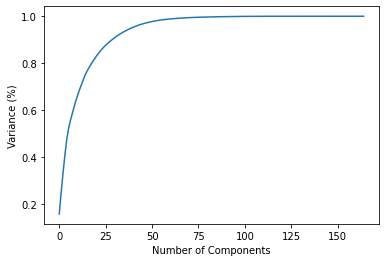

array([ 15.68433691,  24.74667373,  33.10378249,  40.54965109,
        47.39486325,  52.10029515,  55.50687153,  58.50470073,
        61.42530001,  64.16698358,  66.53422149,  68.88994394,
        71.02367211,  73.08023374,  75.02227321,  76.60158477,
        78.0620214 ,  79.39525157,  80.67360492,  81.84725939,
        83.00384916,  84.08061599,  85.07367374,  86.01668656,
        86.88167021,  87.66126402,  88.38898007,  89.07250363,
        89.72934819,  90.35721032,  90.96092432,  91.51678808,
        92.05310805,  92.55542469,  93.03539412,  93.48671903,
        93.90272285,  94.30439446,  94.68386345,  95.03240113,
        95.3773965 ,  95.69977774,  96.00449478,  96.27854221,
        96.53127052,  96.77177334,  96.99681187,  97.20554906,
        97.39294777,  97.57709392,  97.74530298,  97.90443261,
        98.05346752,  98.18960852,  98.31107071,  98.42348617,
        98.52366819,  98.62112629,  98.70982943,  98.7923154 ,
        98.86712008,  98.9372757 ,  99.00342101,  99.06

In [75]:
# PCA 
pca = PCA().fit(train_f0)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()
np.cumsum(pca.explained_variance_ratio_) * 100
# reach 85% variance explained with 23 principle components

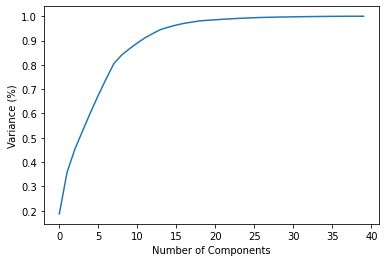

array([ 18.66241111,  35.84253923,  45.30504038,  52.922487  ,
        60.4248241 ,  67.50426855,  74.21093435,  80.54626761,
        84.05727658,  86.62596149,  88.99254744,  91.1645831 ,
        92.92216156,  94.55803141,  95.52117579,  96.38660887,
        97.08481547,  97.60281808,  98.08808651,  98.32139431,
        98.54934806,  98.75599665,  98.94597887,  99.12335478,
        99.26581491,  99.39748682,  99.50860948,  99.5814469 ,
        99.64646238,  99.70346206,  99.75636888,  99.8053512 ,
        99.85332717,  99.89527546,  99.92696851,  99.95199898,
        99.97634481,  99.99802256, 100.        , 100.        ])

In [76]:
#PCA with 40 best components
pca_1 = PCA().fit(train_f0[feats])
plt.figure()
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()
np.cumsum(pca_1.explained_variance_ratio_) * 100
# can use 8 principle compents now

Keeping score: Will test 5 models with Ford_0 data variations,
- Model_0_0 = All varaibles,
- Model_0_1 = PCA All varaibles
- Model_0_2 = 40 best k score
- Model_0_3 = PCA of 40 Best K Score

In [83]:
# Model_0_0 final data prep

# conveting the target to binary categorical
train_f0t = to_categorical(train_f0t)
val_f0t = to_categorical(val_f0t)
test_f0t = to_categorical(test_f0t)

# cononverting to window format, in this case 5 periods
train_X_0_0, train_y_0_0 = df_to_X_y2(train_f0,train_f0t)
val_X_0_0, val_y_0_0 = df_to_X_y2(train_f0,train_f0t)
test_X_0_0, test_y_0_0 = df_to_X_y2(train_f0,train_f0t) 

In [86]:
train_X_0_0.shape[2]

165

In [88]:
n_steps = train_X_0_0.shape[1]
n_features = train_X_0_0.shape[2]

model_0_0_1 = Sequential()
model_0_0_1.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_0_1.add(MaxPooling1D(pool_size=2)) 
model_0_0_1.add(Flatten())
model_0_0_1.add(Dense(50, activation='relu')) 
model_0_0_1.add(Dense(2, activation='softmax'))

model_0_0_1.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics=["accuracy"])

model_0_0_1.fit(train_X_0_0,train_y_0_0,epochs=20,  validation_data=(val_X_0_0, val_y_0_0))

Epoch 1/20
16/16 [==============================] - 1s 17ms/step - loss: 0.6984 - accuracy: 0.5071 - val_loss: 0.6933 - val_accuracy: 0.4908
Epoch 2/20
16/16 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.5092 - val_loss: 0.6925 - val_accuracy: 0.5255
Epoch 3/20
16/16 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5132 - val_loss: 0.6928 - val_accuracy: 0.5193
Epoch 4/20
16/16 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.5214 - val_loss: 0.6921 - val_accuracy: 0.5255
Epoch 5/20
16/16 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5295 - val_loss: 0.6915 - val_accuracy: 0.5255
Epoch 6/20
16/16 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5295 - val_loss: 0.6920 - val_accuracy: 0.5540
Epoch 7/20
16/16 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5336 - val_loss: 0.6911 - val_accuracy: 0.5275
Epoch 8/20
16/16 [=

In [89]:
model_0_0_2 = Sequential()
model_0_0_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_0_2.add(MaxPooling1D(pool_size=2)) 
model_0_0_2.add(Flatten())
model_0_0_2.add(Dense(50, activation='relu')) 
model_0_0_2.add(Dense(2, activation='softmax'))

model_0_0_2.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics=["accuracy"])

model_0_0_2.fit(train_X_0_0,train_y_0_0,epochs=20,  validation_data=(val_X_0_0, val_y_0_0))

Epoch 1/20
16/16 [==============================] - 1s 16ms/step - loss: 0.7224 - accuracy: 0.4868 - val_loss: 0.7068 - val_accuracy: 0.4827
Epoch 2/20
16/16 [==============================] - 0s 8ms/step - loss: 0.7041 - accuracy: 0.5031 - val_loss: 0.6886 - val_accuracy: 0.5356
Epoch 3/20
16/16 [==============================] - 0s 8ms/step - loss: 0.6963 - accuracy: 0.4929 - val_loss: 0.6844 - val_accuracy: 0.5540
Epoch 4/20
16/16 [==============================] - 0s 6ms/step - loss: 0.6845 - accuracy: 0.5540 - val_loss: 0.6796 - val_accuracy: 0.5356
Epoch 5/20
16/16 [==============================] - 0s 7ms/step - loss: 0.6837 - accuracy: 0.5560 - val_loss: 0.6738 - val_accuracy: 0.5845
Epoch 6/20
16/16 [==============================] - 0s 9ms/step - loss: 0.6806 - accuracy: 0.5642 - val_loss: 0.6682 - val_accuracy: 0.6477
Epoch 7/20
16/16 [==============================] - 0s 7ms/step - loss: 0.6699 - accuracy: 0.6171 - val_loss: 0.6599 - val_accuracy: 0.6558
Epoch 8/20
16/16 [=

In [91]:
model_0_0_3 = Sequential()
model_0_0_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_0_3.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_0_3.add(MaxPooling1D(pool_size=2)) 
model_0_0_3.add(Flatten())
model_0_0_3.add(Dense(50, activation='relu')) 
model_0_0_3.add(Dense(2, activation='softmax')) 

model_0_0_3.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics=["accuracy"])

model_0_0_3.fit(train_X_0_0,train_y_0_0,epochs=20,  validation_data=(val_X_0_0, val_y_0_0))

Epoch 1/20
16/16 [==============================] - 1s 17ms/step - loss: 0.6966 - accuracy: 0.5010 - val_loss: 0.6852 - val_accuracy: 0.5703
Epoch 2/20
16/16 [==============================] - 0s 11ms/step - loss: 0.6863 - accuracy: 0.5499 - val_loss: 0.6822 - val_accuracy: 0.5234
Epoch 3/20
16/16 [==============================] - 0s 8ms/step - loss: 0.6847 - accuracy: 0.5438 - val_loss: 0.6727 - val_accuracy: 0.6538
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.6762 - accuracy: 0.5723 - val_loss: 0.6650 - val_accuracy: 0.6049
Epoch 5/20
16/16 [==============================] - 0s 8ms/step - loss: 0.6636 - accuracy: 0.6497 - val_loss: 0.6550 - val_accuracy: 0.6884
Epoch 6/20
16/16 [==============================] - 0s 13ms/step - loss: 0.6582 - accuracy: 0.6212 - val_loss: 0.6439 - val_accuracy: 0.7088
Epoch 7/20
16/16 [==============================] - 0s 13ms/step - loss: 0.6440 - accuracy: 0.6965 - val_loss: 0.6340 - val_accuracy: 0.6599
Epoch 8/20
16/16

In [92]:
model_0_0_4 = Sequential()
model_0_0_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_0_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_0_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_0_4.add(MaxPooling1D(pool_size=2)) 
model_0_0_4.add(Flatten())
model_0_0_4.add(Dense(50, activation='relu')) 
model_0_0_4.add(Dense(2, activation='softmax')) 
model_0_0_4.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics=["accuracy"])

model_0_0_4.fit(train_X_0_0,train_y_0_0,epochs=20,  validation_data=(val_X_0_0, val_y_0_0))

Epoch 1/20
16/16 [==============================] - 1s 17ms/step - loss: 0.7003 - accuracy: 0.5295 - val_loss: 0.6911 - val_accuracy: 0.5458
Epoch 2/20
16/16 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4868 - val_loss: 0.6901 - val_accuracy: 0.5927
Epoch 3/20
16/16 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.5234 - val_loss: 0.6874 - val_accuracy: 0.5275
Epoch 4/20
16/16 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5112 - val_loss: 0.6881 - val_accuracy: 0.5255
Epoch 5/20
16/16 [==============================] - 0s 8ms/step - loss: 0.6892 - accuracy: 0.5193 - val_loss: 0.6850 - val_accuracy: 0.5418
Epoch 6/20
16/16 [==============================] - 0s 8ms/step - loss: 0.6859 - accuracy: 0.5418 - val_loss: 0.6869 - val_accuracy: 0.5621
Epoch 7/20
16/16 [==============================] - 0s 10ms/step - loss: 0.6864 - accuracy: 0.5438 - val_loss: 0.6764 - val_accuracy: 0.6497
Epoch 8/20
16/16 [

Model_0_0_3 appears to be an initial best using all the data. Will use this one with the test data.